<a href="https://colab.research.google.com/github/dcolinmorgan/prediction/blob/master/tpu_midjune_fullLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os,glob,gc
import pandas as pd
import numpy as np
from psutil import *
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns
import math,keras,time
import tensorflow as tf
# import cupy as cp

timestr = time.strftime("%Y%m%d")

check https://www.tensorflow.org/tutorials/structured_data/time_series

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# ##CASE
## import tarfile
# t4data=pd.DataFrame(np.load('drive/My Drive/LARGE_PANDA/LTRCcase.npy'))

# # #CONTROL
# tdata=pd.DataFrame(np.load('drive/My Drive/LARGE_PANDA/LTRCcontrol.npy'))

links=pd.read_csv('drive/My Drive/harvard/LARGE_COPD/LARGECOPD_links.txt',header=None,names=['TF','gene'])

# np.savez_compressed('drive/My Drive/harvard/LARGE_COPD/LTRC.npz', array1=t4data, array2=tdata)

data=np.load('drive/My Drive/harvard/LARGE_COPD/LTRC.npz')

t4data=pd.DataFrame(data['array1'])
t4data.columns=pd.read_csv('drive/My Drive/harvard/LARGE_COPD/LTRCcase_ages.txt',header=None)[0]

tdata=pd.DataFrame(data['array2'])
tdata.columns=pd.read_csv('drive/My Drive/harvard/LARGE_COPD/LTRCcontrol_ages.txt',header=None)[0]


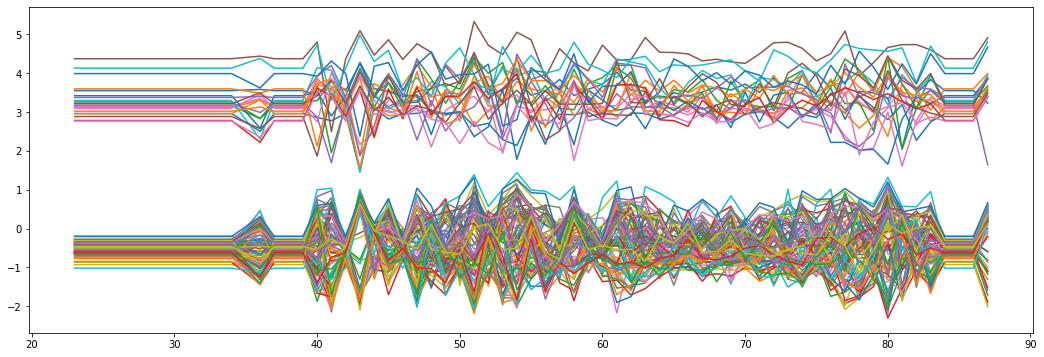

In [5]:
plt.figure(figsize=(18, 6))
w=plt.plot(tdata.T.iloc[:,1:100])

In [6]:
from scipy.stats import zscore
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pandas.tseries.offsets import DateOffset

# from keras.preprocessing import timeseries_dataset_from_array
# from keras.utils import plot_model
from keras.models import load_model

from keras import Sequential
from keras.layers import Dense, LSTM, Conv1D, Bidirectional, Lambda,Dropout,Activation,RepeatVector,TimeDistributed
from keras.callbacks import EarlyStopping, LearningRateScheduler,ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.sequence import TimeseriesGenerator

In [7]:
tf.keras.backend.clear_session()
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

strategy = tf.distribute.TPUStrategy(resolver)


INFO:tensorflow:Initializing the TPU system: grpc://10.81.185.138:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.81.185.138:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]
INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


##look at data first, normalize

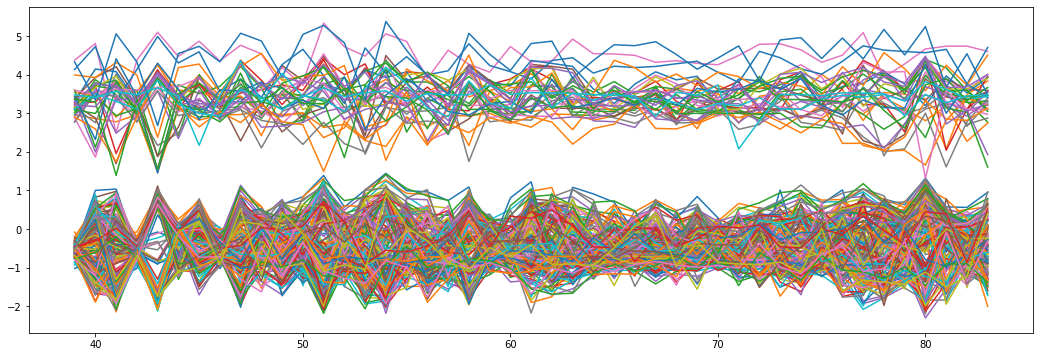

In [8]:
plt.figure(figsize=(18, 6))
w=plt.plot(tdata.T.iloc[8:53,0:200])

In [9]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))

jj=np.random.choice(range(0,len(tdata)),size=20000,replace=False)
kk=np.random.choice(range(0,len(tdata)),size=20000,replace=False)

t2data = scaler.fit_transform(tdata.T.iloc[8:53,jj])#cont_gene_sum.iloc[:,10:50])) #r2data.iloc[:,10:50]))
t3data = scaler.fit_transform(tdata.T.iloc[8:53,kk])

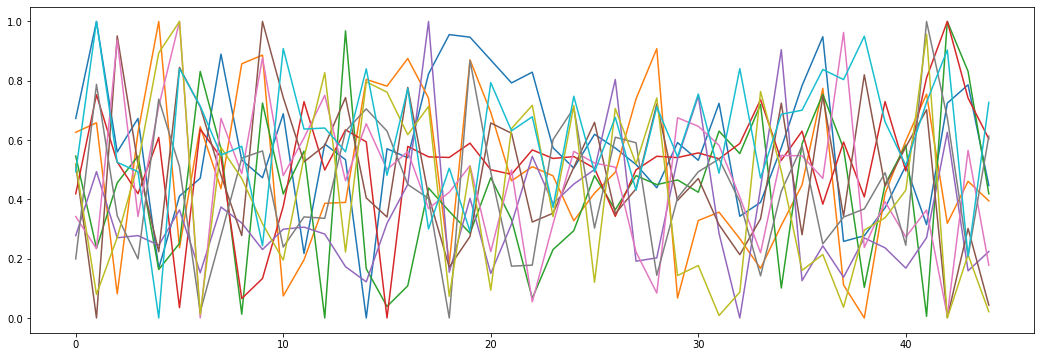

In [10]:
plt.figure(figsize=(18, 6))
w=plt.plot(pd.DataFrame(t2data).iloc[:,0:10])

In [11]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))

jj=np.random.choice(range(0,len(t4data)),size=20000,replace=False)
kk=np.random.choice(range(0,len(t4data)),size=20000,replace=False)

t5data = scaler.fit_transform(t4data.T.iloc[8:53,jj])#cont_gene_sum.iloc[:,10:50])) #r2data.iloc[:,10:50]))
t6data = scaler.fit_transform(t4data.T.iloc[8:53,kk])

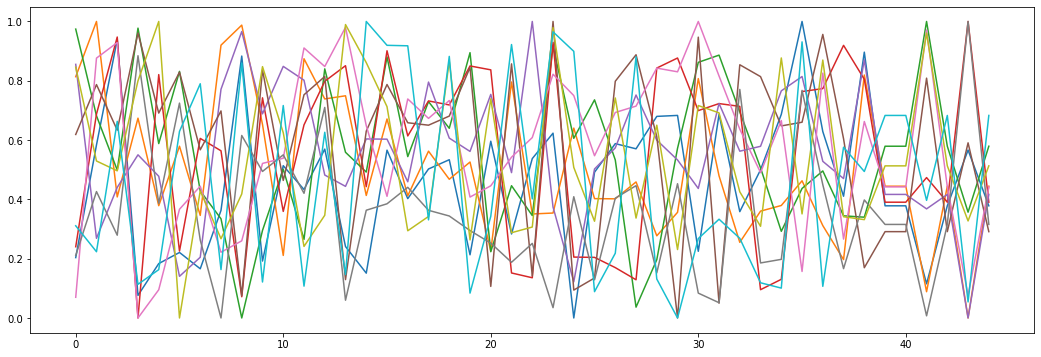

In [12]:
plt.figure(figsize=(18, 6))
w=plt.plot(pd.DataFrame(t5data).iloc[:,0:10])

## begin reworked model

[tutorial here](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/)

In [13]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)


In [14]:
dataset=t2data[:,0:200]

# choose a number of time steps
n_steps_in, n_steps_out = 40, 5
# covert into input/output
# X, y = split_sequences(dataset, n_steps_in, n_steps_out)
X=np.expand_dims(dataset[0:40,:],axis=0)
y=np.expand_dims(dataset[40:45,:],axis=0)

print([X.shape,y.shape])
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]


[(1, 40, 200), (1, 5, 200)]


In [15]:
# ww=(dataset.T[8:53,dataset.shape[1]*jeff:dataset.shape[1]*(jeff+1)])

# ww.shape
# x1_input=np.expand_dims(ww[0:40,:],axis=0)
# y1=np.expand_dims(ww[40:45,:],axis=0)
# print(x1_input.shape,y1.shape)
# X2, y2 = split_sequences(ww, n_steps_in, n_steps_out)
# zz=np.flip(ww,axis=0)
# print(y2,shape)

In [16]:
dataset=t5data[:,0:200]

# choose a number of time steps
n_steps_in, n_steps_out = 40, 5
# covert into input/output
# X1, y1 = split_sequences(dataset, n_steps_in, n_steps_out)
X1=np.expand_dims(dataset[0:40,:],axis=0)
y1=np.expand_dims(dataset[40:45,:],axis=0)

print([X1.shape,y1.shape])
# the dataset knows the number of features, e.g. 2
n_features = X1.shape[2]

# strategy = tf.distribute.TPUStrategy(resolver)


[(1, 40, 200), (1, 5, 200)]


In [39]:
with strategy.scope():
  model = Sequential()
  model.add(LSTM(2000, activation='relu', input_shape=(n_steps_in, n_features)))
  model.add(RepeatVector(n_steps_out))

  # model.add(Bidirectional(LSTM(2000,activation='relu',return_sequences=True)))
  # model.add(Dropout(0.5))
  model.add(LSTM(2000, activation='relu', return_sequences=True))
  model.add(TimeDistributed(Dense(n_features)))
  model.compile(optimizer='adam', loss='mse',steps_per_execution = 10)
  print(model.summary())

  # history = model.fit(X,y, epochs=300,validation_split=.5,callbacks=callbacks,verbose=0)


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 2000)              17608000  
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 5, 2000)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 5, 2000)           32008000  
_________________________________________________________________
time_distributed_3 (TimeDist (None, 5, 200)            400200    
Total params: 50,016,200
Trainable params: 50,016,200
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(X1, y1, epochs=500)#,verbose=0) ## swap training with X for X1 and back

model.save('~/drive/MyDrive/harvard/LARGE_COPD/model_output/case_tutorial_model_'+timestr+'.h5')
# plot_model(model, to_file='drive/MyDrive/LARGE_PANDA/model_output/420_tutorial_model_'+timestr+'.png', show_shapes=True)
# Image(filename='drive/MyDrive/LARGE_PANDA/model_output/420_tutorial_model_'+timestr+'.png')


In [41]:
from keras.models import load_model
# model = load_model('/content/drive/MyDrive/LARGE_PANDA/model_output/Cont_geneoutdegree_20210414-2043.h')
model = load_model('~/drive/MyDrive/harvard/LARGE_COPD/model_output/case_tutorial_model_'+timestr+'.h5')
# model=load_model('/content/drive/MyDrive/LARGE_PANDA/model_output/420_tutorial_model_20210421-1655.h5')
model.compile(loss='mse',
              experimental_steps_per_execution = 50,
              optimizer='adam',
              metrics=['mse'])

### very overfit -- any input returns yhat = initial y

In [42]:
jeff=np.random.randint(99)

x_input = np.expand_dims(t2data[0:40,dataset.shape[1]*jeff:dataset.shape[1]*(jeff+1)],axis=0) ## take next batch of links
yhat = model.predict(x_input, verbose=0)
y_0=np.expand_dims(t2data[40:45,dataset.shape[1]*jeff:dataset.shape[1]*(jeff+1)],axis=0)

x1_input = np.expand_dims(t5data[0:40,dataset.shape[1]*jeff:dataset.shape[1]*(jeff+1)],axis=0) ## take next batch of links
y1hat = model.predict(x1_input, verbose=0)
y_1=np.expand_dims(t5data[40:45,dataset.shape[1]*jeff:dataset.shape[1]*(jeff+1)],axis=0)


print(jeff)

75


In [43]:
[X.shape,y.shape,yhat.shape]

[(32910, 40, 200), (32910, 5, 200), (1, 5, 200)]

In [44]:
trainScore = math.sqrt(mean_squared_error(yhat[0], y_0[0]))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 0.44 RMSE


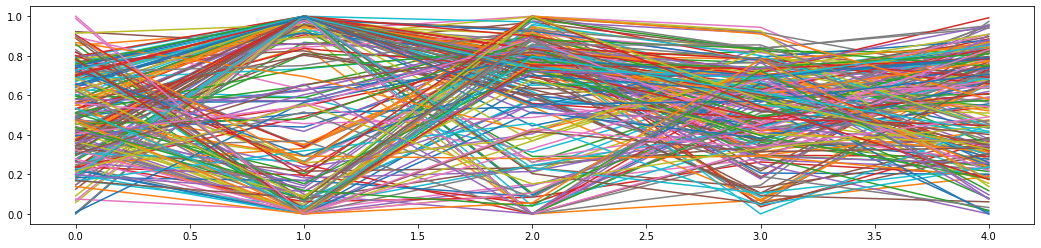

In [45]:
plt.figure(figsize=(18, 4))
c=plt.plot(y_0[0])

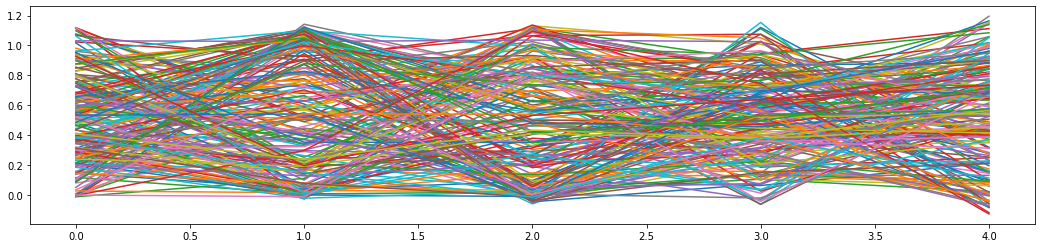

In [46]:
plt.figure(figsize=(18, 4))
c=plt.plot(yhat[0])

In [47]:
t2data[0:40,200:400].shape

(40, 200)

In [52]:
trainScore = math.sqrt(mean_squared_error(y1hat[0], y1[0]))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 0.02 RMSE


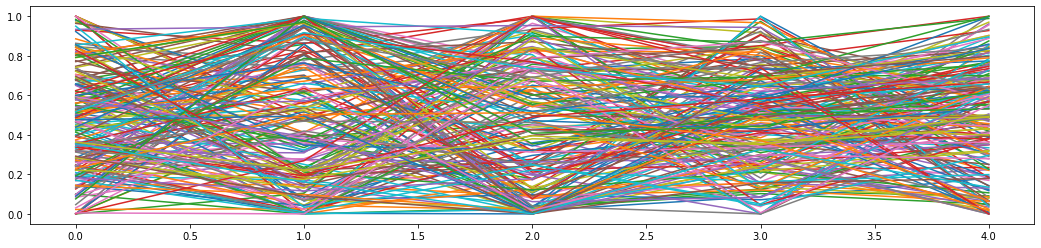

In [53]:
plt.figure(figsize=(18, 4))
c=plt.plot(y1[0])

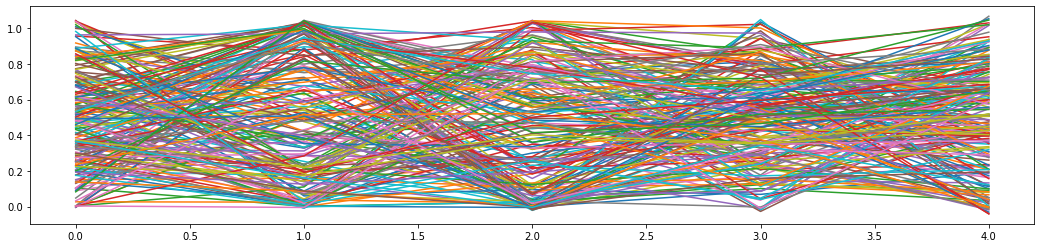

In [50]:
plt.figure(figsize=(18, 4))
c=plt.plot(y1hat[0])

folding data is same as function for binning

In [29]:
dataset=t2data[:,0:200]

# choose a number of time steps
n_steps_in, n_steps_out = 40, 5
# covert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
print([X.shape,y.shape])

[(1, 40, 200), (1, 5, 200)]


In [30]:
# jeff=np.random.randint(99)
# ww=scaler.fit_transform(t4data.T.iloc[8:48,dataset.shape[1]*jeff:dataset.shape[1]*(jeff+1)])
# ww=(t4data.T.iloc[8:53,dataset.shape[1]*jeff:dataset.shape[1]*(jeff+1)])
ww=dataset
x1_input=np.expand_dims(ww[0:40,],axis=0)
y1=np.expand_dims(ww[40:45,:],axis=0)
# x1_input = np.expand_dims(dd,axis=0) ## take next batch of links
y1hat = model.predict(x1_input, verbose=0)
# print(jeff)

trainScore = math.sqrt(mean_squared_error(y1[0], y[0]))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 0.00 RMSE


but doesnt generalize... so each link needs to be trained on :( 
  
so now figure out how to fold/ batch everything

---



In [31]:
# ww=scaler.fit_transform(t5data.T[8:48,:])

ww=t5data
x2_input=np.expand_dims(ww[0:40,1:201],axis=0)
y2=np.expand_dims(ww[40:45,1:201],axis=0)

# x1_input = np.expand_dims(t5data[0:40,dataset.shape[1]*jeff:dataset.shape[1]*(jeff+1)],axis=0) ## take next batch of links
y2hat = model.predict(x2_input, verbose=0)

trainScore = math.sqrt(mean_squared_error(y2hat[0], y2[0]))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 0.80 RMSE


learn with more links

In [57]:
train=int(800*(1097*.75))  ##trying smaller set, vs 8000
test=int(800*(1097*.25))

TData=tdata.iloc[0:train,:]
n_steps_in, n_steps_out = 40, 5

t2data = scaler.fit_transform(TData.T.iloc[8:53,])

X=np.reshape(t2data[0:len(t2data)-n_steps_out],(len(t2data)-n_steps_out,int(t2data.shape[1]/(200)),200),order='A')
print(sum(sum(t2data[0:5,200:205]==X[0:5,1,0:5]))==25)
X=np.swapaxes(X,0,1)

y=np.reshape(t2data[len(t2data)-n_steps_out:],(n_steps_out,int(t2data.shape[1]/(200)),200),order='A')
y=np.swapaxes(y,0,1)
print([X.shape,y.shape])


True
[(3291, 40, 200), (3291, 5, 200)]


In [58]:
callbacks = [
    LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20)),
    EarlyStopping(patience=5, verbose=1,monitor='loss'),
    ReduceLROnPlateau(factor=0.1, patience=2,min_lr=0.1, verbose=1),
    ModelCheckpoint('model.h5', verbose=1, save_best_only=True, save_weights_only=False)
]

In [ ]:
history = model.fit(X, y, epochs=500,batch_size=64,validation_split=.2,callbacks=callbacks,verbose=1,use_multiprocessing=True)

Epoch 1/500
42/42 [==============================] - 30s 704ms/step - loss: 0.1360 - mse: 0.1360 - val_loss: 0.1290 - val_mse: 0.1290

Epoch 00001: val_loss improved from 0.13167 to 0.12895, saving model to model.h5
Epoch 2/500
42/42 [==============================] - 28s 676ms/step - loss: 0.1332 - mse: 0.1332 - val_loss: 0.1263 - val_mse: 0.1263

Epoch 00002: val_loss improved from 0.12895 to 0.12627, saving model to model.h5
Epoch 3/500
42/42 [==============================] - 28s 678ms/step - loss: 0.1305 - mse: 0.1305 - val_loss: 0.1236 - val_mse: 0.1236

Epoch 00003: val_loss improved from 0.12627 to 0.12359, saving model to model.h5
Epoch 4/500
42/42 [==============================] - 28s 673ms/step - loss: 0.1278 - mse: 0.1278 - val_loss: 0.1209 - val_mse: 0.1209

Epoch 00004: val_loss improved from 0.12359 to 0.12095, saving model to model.h5
Epoch 5/500
42/42 [==============================] - 28s 676ms/step - loss: 0.1251 - mse: 0.1251 - val_loss: 0.1184 - val_mse: 0.1184

E

In [ ]:
# model.save('~/drive/MyDrive/harvard/LARGE_COPD/model_output/case_largeJune_model_'+timestr+'.h5')
from keras.models import load_model
# model = load_model('/content/drive/MyDrive/LARGE_PANDA/model_output/Cont_geneoutdegree_20210414-2043.h')
model = load_model('~/drive/MyDrive/harvard/LARGE_COPD/model_output/case_largeJune_model_'+timestr+'.h5')
# model=load_model('/content/drive/MyDrive/LARGE_PANDA/model_output/420_tutorial_model_20210421-1655.h5')
model.compile(loss='mse',
              experimental_steps_per_execution = 50,
              optimizer='adam',
              metrics=['mse'])

In [ ]:
TData.shape

In [ ]:

TData=tdata.iloc[train:train+test,:]
n_steps_in, n_steps_out = 40, 5

t3data = scaler.fit_transform(TData.T.iloc[8:53,])

X1=np.reshape(t3data[0:len(t3data)-n_steps_out],(len(t3data)-n_steps_out,int(t3data.shape[1]/(200)),200),order='A')
print(sum(sum(t3data[0:5,200:205]==X[0:5,1,0:5]))==25)
X1=np.swapaxes(X1,0,1)

y1=np.reshape(t3data[len(t3data)-n_steps_out:],(n_steps_out,int(t3data.shape[1]/(200)),200),order='A')
y1=np.swapaxes(y1,0,1)
print([X1.shape,y1.shape])


In [ ]:
jeff=np.random.randint(99)
# x_input = np.expand_dims(t2data[0:40,dataset.shape[1]*jeff:dataset.shape[1]*(jeff+1)],axis=0) ## take next batch of links
y1hat = model.predict(X1, verbose=0)

trainScore = math.sqrt(mean_squared_error(y1hat[0], y1[0]))
print('Train Score: %.2f RMSE' % (trainScore))

In [ ]:
plt.figure(figsize=(18, 4))
c=plt.plot(y1hat[0])

In [ ]:
plt.figure(figsize=(18, 4))
c=plt.plot(y1[0])

In [ ]:

TData=t4data.iloc[train:train+test,:]
n_steps_in, n_steps_out = 40, 5

t3data = scaler.fit_transform(TData.T.iloc[8:53,])

X=np.reshape(t3data[0:len(t3data)-n_steps_out],(len(t3data)-n_steps_out,int(t3data.shape[1]/(200)),200),order='A')
print(sum(sum(t3data[0:5,200:205]==X[0:5,1,0:5]))==25)
X=np.swapaxes(X,0,1)

y=np.reshape(t3data[len(t3data)-n_steps_out:],(n_steps_out,int(t3data.shape[1]/(200)),200),order='A')
y=np.swapaxes(y,0,1)
print([X.shape,y.shape])


In [ ]:
# jeff=np.random.randint(99)
# x_input = np.expand_dims(t2data[0:40,dataset.shape[1]*jeff:dataset.shape[1]*(jeff+1)],axis=0) ## take next batch of links
yhat = model.predict(X, verbose=0)

trainScore = math.sqrt(mean_squared_error(yhat[0], y[0]))
print('Train Score: %.2f RMSE' % (trainScore))

In [ ]:
plt.figure(figsize=(18, 4))
c=plt.plot(y[0])

In [ ]:
plt.figure(figsize=(18, 4))
c=plt.plot(yhat[0])

In [ ]:
plt.figure(figsize=(18, 4))
c=plt.plot(y1hat[0])